In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import numpy as np
from scipy.optimize import curve_fit
import jax
import jax.numpy as jnp
import tqdm
from joblib import Parallel, delayed
from itertools import product
from scipy.optimize import OptimizeWarning
import warnings

In [2]:
def simulate_logistic(T, x0=0.2, r=3.9):
    x = np.zeros(T); x[0] = x0
    for t in range(T-1):
        x[t+1] = r * x[t] * (1 - x[t])
    return x


In [3]:
import jax
import jax.numpy as jnp
from jax import random, vmap
from functools import partial
from jax import lax
from jax.nn import sigmoid, tanh
import jax.nn as jnn

def define_pars(key, hidden_size, input_dim,
                bias_scale, vol, normalize=False):

    kW_i,kW_f,kW_c,kW_o, kU_i,kU_f,kU_c,kU_o = random.split(key, 8)

    h_scale = vol / jnp.sqrt(hidden_size) if normalize else vol
    x_scale = vol / jnp.sqrt(input_dim)   if normalize else vol

    def randW(k, out_dim, in_dim, scl):  
        return random.normal(k, (in_dim, out_dim)) * scl

    W_i = randW(kW_i, hidden_size, hidden_size, h_scale)
    W_f = randW(kW_f, hidden_size, hidden_size, h_scale)
    W_c = randW(kW_c, hidden_size, hidden_size, h_scale)
    W_o = randW(kW_o, hidden_size, hidden_size, h_scale)

    U_i = randW(kU_i, hidden_size, input_dim,  x_scale)
    U_f = randW(kU_f, hidden_size, input_dim,  x_scale)
    U_c = randW(kU_c, hidden_size, input_dim,  x_scale)
    U_o = randW(kU_o, hidden_size, input_dim,  x_scale)

    b_i = jnp.zeros(hidden_size) + bias_scale
    b_f = jnp.zeros(hidden_size) + bias_scale
    b_c = jnp.zeros(hidden_size) + bias_scale
    b_o = jnp.zeros(hidden_size) + bias_scale

    return W_i,W_f,W_c,W_o, U_i,U_f,U_c,U_o, b_i,b_f,b_c,b_o

def single_lstm_cell(key, x_seq,               
                     hidden_size, bias_scale,
                     vol, normalize=False):

    T, input_dim = x_seq.shape
    pars = define_pars(key, hidden_size, input_dim,
                       bias_scale, vol, normalize)

    (W_i,W_f,W_c,W_o, U_i,U_f,U_c,U_o,
     b_i,b_f,b_c,b_o) = pars

    h0 = random.normal(key)*jnp.ones(hidden_size)
    c0 = jnp.zeros(hidden_size)

    def f_scan(carry, x_t):
        h, c = carry
        i = jnn.sigmoid(h @ W_i + x_t @ U_i + b_i)
        f = jnn.sigmoid(h @ W_f + x_t @ U_f + b_f)
        o = jnn.sigmoid(h @ W_o + x_t @ U_o + b_o)
        c_hat = jnp.tanh(h @ W_c + x_t @ U_c + b_c)

        c = f * c + i * c_hat
        h = o * jnp.tanh(c)
        return (h, c), h

    (h_T, c_T), h_seq = lax.scan(f_scan, (h0, c0), x_seq)
    return (h_T, c_T), h_seq 

def LSTMCell_test(keys, x_seq,
                  hidden_size, bias_scale,
                  vol, normalize=False):
  
    cell_fixed = partial(single_lstm_cell,
                         x_seq=x_seq,
                         hidden_size=hidden_size,
                         bias_scale=bias_scale,
                         vol=vol,
                         normalize=normalize)
    h_final, h_seq = jax.vmap(cell_fixed)(keys)
    return h_seq

In [4]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import random


num_steps = 10000
r, x0 = 3.9, 0.21
 

series_raw = simulate_logistic(num_steps, x0, r)
x_mean, x_std = series_raw.mean(), series_raw.std()
x_scaled      = (series_raw - x_mean) / x_std        # shape (T,)
x_seq         = jnp.asarray(x_scaled)[:, None]


key = jax.random.PRNGKey(0)
hidden_size = 100
g_factors = jnp.linspace(0.5, 1.5, 20)  
g_critico = 2 / jnp.sqrt(hidden_size)
g = g_factors * g_critico  
num_seeds = 1000  
k = 2
bias = 0.0275 #* jnp.linspace(1, 4, 6)  

seeds = random.split(key, num_seeds)

In [5]:
Y = LSTMCell_test(seeds, x_seq, hidden_size, bias, g_critico, normalize=False)

In [6]:
def ridge_readout(
        Y, series,
        k=1,
        lam=1e-1,
        train_ratio=0.7,
        seed=42,
        dtype=np.float32):

    R, T, N = Y.shape
    L = T - k

    #vettore readout condiviso
    rng = np.random.default_rng(seed)
    w_rand = rng.standard_normal(N, dtype=dtype) / np.sqrt(N)

    #proiezione
    P = np.einsum('rtn,n->rt', Y.astype(dtype), w_rand, optimize=True).T  # (T,R)

    A = P[:-k]                
    y = series[k:]

    split = int(train_ratio * L)
    y_tr_mean, y_tr_std = y[:split].mean(), y[:split].std()
    y_scaled = (y - y_tr_mean) / y_tr_std

    A_tr, y_tr = A[:split], y_scaled[:split]
    A_te, y_te = A[split:], y_scaled[split:]

    G = A_tr.T @ A_tr
    I = np.eye(R, dtype=G.dtype)   
    G = G + lam * I               

    alpha = np.linalg.solve(G, A_tr.T @ y_tr).astype(dtype)

    rmse_tr = np.sqrt(((y_tr - A_tr @ alpha) ** 2).mean()) * y_tr_std
    rmse_te = np.sqrt(((y_te - A_te @ alpha) ** 2).mean()) * y_tr_std


    W_eff = alpha[:, None] * w_rand[None, :]    # (R,N)

    return alpha.astype(np.float64), w_rand.astype(np.float64), rmse_tr, rmse_te, W_eff


In [7]:
alpha, W_rand, rmse_tr, rmse_te, W_eff = ridge_readout(
    Y[:,500:,:], series_raw[500:], k = 2,lam=0.0001, train_ratio=0.7, seed=42) #burn in

RMSE train: 0.0431
RMSE test : 0.0860


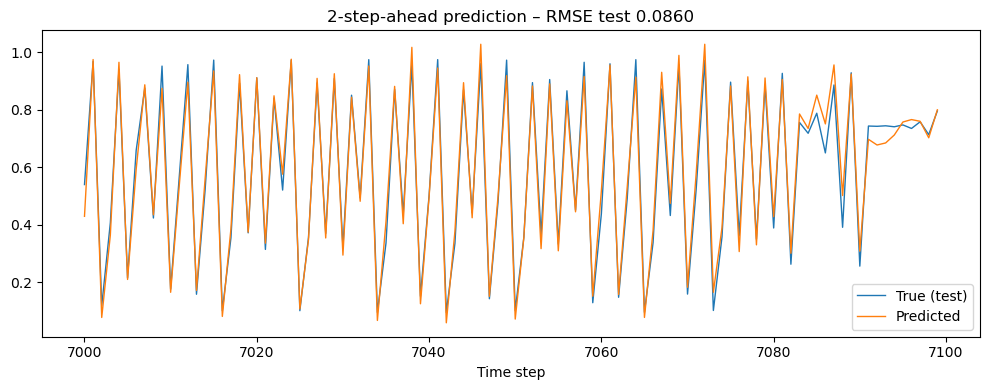

In [10]:
k = 2
train_ratio = 0.7
print(f"RMSE train: {rmse_tr:.4f}")
print(f"RMSE test : {rmse_te:.4f}")


P = np.einsum('rtn,n->rt', Y, W_rand).T   # (T, R)

y_true = series_raw[k:]                   # tempi t+k
num_steps = series_raw.size
split = int(train_ratio * (num_steps - k))


y_mean_tr = y_true[:split].mean()
y_std_tr  = y_true[:split].std()


y_scaled_pred = P[:-k] @ alpha            # (T‑k,)
y_pred = y_scaled_pred * y_std_tr + y_mean_tr

# serie di test
t_test    = np.arange(split + k, num_steps)   
y_true_te = y_true[split:]                    
y_pred_te = y_pred[split:]                    


#plot

plt.figure(figsize=(10, 4))
plt.plot(t_test[:100], y_true_te[:100], label='True (test)', lw=1)
plt.plot(t_test[:100], y_pred_te[:100], label='Predicted', lw=1)
plt.title(f'{k}-step‑ahead prediction – RMSE test {rmse_te:.4f}')
plt.xlabel('Time step')
plt.legend()
plt.tight_layout()
plt.show()

